In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ammarufr","key":"39d611022241bebf409f954ac9cbc2cc"}'}

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
# Download dataset daun jambu mete
!kaggle datasets download -d nirmalsankalana/crop-pest-and-disease-detection
!unzip -q crop-pest-and-disease-detection.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/crop-pest-and-disease-detection
License(s): CC0-1.0
crop-pest-and-disease-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/Cashew anthracnose/anthracnose1000_.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [5]:
# Download dataset non-leaf (contoh: gambar random objek non-daun)
!kaggle datasets download -d lprdosmil/unsplash-random-images-collection
!unzip -q unsplash-random-images-collection.zip -d dataset/non-leaf  # Anggap ini mewakili non-leaf

Dataset URL: https://www.kaggle.com/datasets/lprdosmil/unsplash-random-images-collection
License(s): CC0-1.0
unsplash-random-images-collection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/non-leaf/unsplash-images-collection/photo-1433162653888-a571db5ccccf.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
classes = ['Cashew anthracnose', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'non-leaf']
base_path = 'dataset'
split_base = 'split_dataset'
splits = ['train', 'val', 'test']
split_ratio = {'train': 0.8, 'val': 0.1, 'test': 0.1}

# Buat folder split
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base, split, cls), exist_ok=True)

# Proses bagi untuk setiap kelas
for cls in classes:
    if cls == 'non-leaf':
        src_dir = os.path.join(base_path, 'non-leaf')  # Ambil dari dataset animal
        sub_dirs = [os.path.join(src_dir, sub) for sub in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, sub))]
        all_images = []
        for sub in sub_dirs:
            all_images += [os.path.join(sub, img) for img in os.listdir(sub)]
    else:
        src_dir = os.path.join(base_path, cls)
        all_images = [os.path.join(src_dir, img) for img in os.listdir(src_dir)]

    random.shuffle(all_images)
    total = len(all_images)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_data = {
        'train': all_images[:train_end],
        'val': all_images[train_end:val_end],
        'test': all_images[val_end:]
    }

    for split in splits:
        for img_path in split_data[split]:
            shutil.copy(img_path, os.path.join(split_base, split, cls, os.path.basename(img_path)))

print("Dataset dibagi dengan kelas 'non-leaf'.")

Dataset dibagi dengan kelas 'non-leaf'.


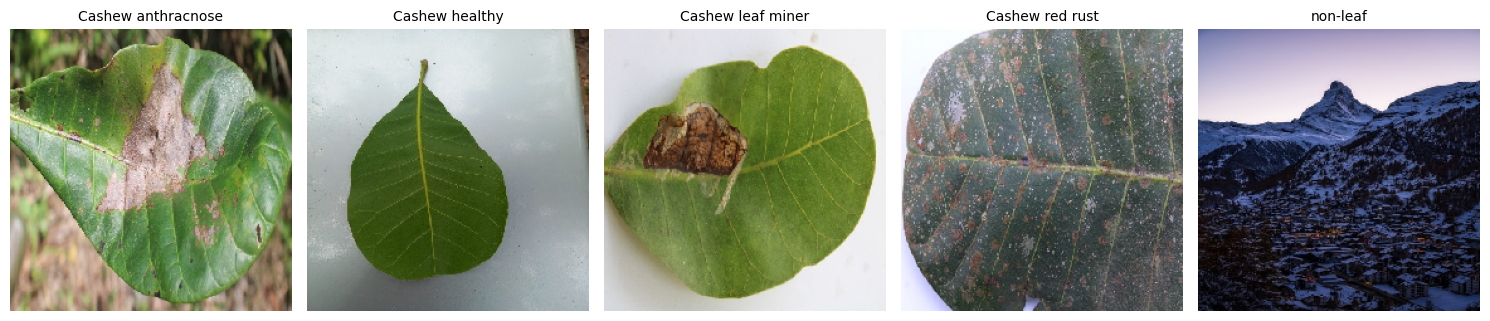

In [7]:
# Lokasi data training hasil split
train_dir = os.path.join(split_base, 'train')

# Siapkan visualisasi
plt.figure(figsize=(15, 5))

for idx, cls in enumerate(classes):
    class_dir = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)

    # Load gambar
    img = load_img(img_path, target_size=(224, 224))

    # Tampilkan gambar
    plt.subplot(1, len(classes), idx + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2,
                                   horizontal_flip=True, shear_range=0.2)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_base, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_base, 'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_base, 'test'),
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 6681 images belonging to 5 classes.
Found 1326 images belonging to 5 classes.
Found 1330 images belonging to 5 classes.


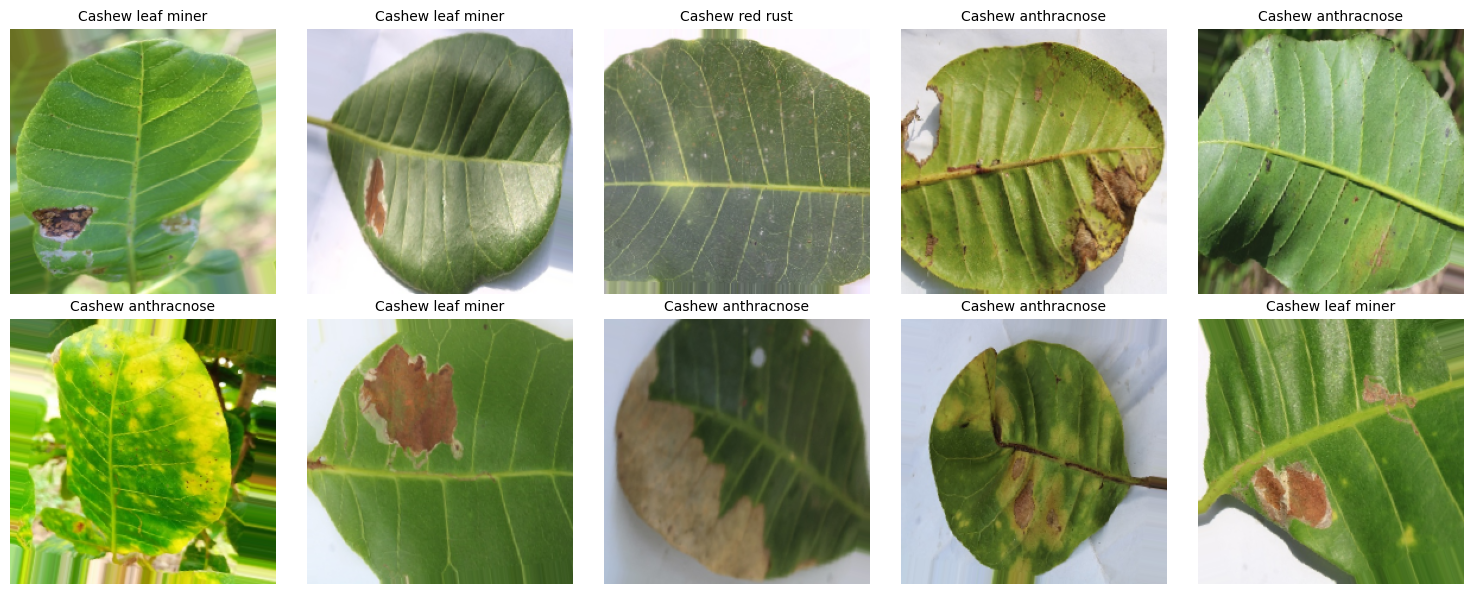

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil satu batch dari train_generator
images, labels = next(train_generator)

# Ambil label dari generator (dalam bentuk indeks ke nama kelas)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Tampilkan 10 gambar pertama
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    class_name = idx_to_class[np.argmax(labels[i])]
    plt.title(class_name, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 kelas

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)
callbacks = [early_stop, reduce_lr]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 199s 664ms/step - accuracy: 0.4870 - loss: 1.3318 - val_accuracy: 0.1192 - val_loss: 6.1344 - learning_rate: 1.0000e-05
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 104s 499ms/step - accuracy: 0.8590 - loss: 0.4137 - val_accuracy: 0.1192 - val_loss: 9.7227 - learning_rate: 1.0000e-05
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 105s 501ms/step - accuracy: 0.9079 - loss: 0.2759 - val_accuracy: 0.1207 - val_loss: 5.3749 - learning_rate: 1.0000e-05
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 104s 498ms/step - accuracy: 0.9348 - loss: 0.1981 - val_accuracy: 0.6026 - val_loss: 1.1786 - learning_rate: 1.0000e-05
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 105s 500ms/step - accuracy: 0.9439 - loss: 0.1684 - val_accuracy: 0.9600 - val_loss: 0.1400 - learning_rate: 1.0000e-05
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 105s 502ms/step - accuracy: 0.9543 - loss: 0.1401 - val_accuracy: 0.9827 - val_loss: 0.0580 - learning_rate: 1.0000e-05
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi pada test set: {test_acc:.2%}")

1330/1330 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9949 - loss: 0.0400
Akurasi pada test set: 99.55%


In [14]:
# Tampilkan nilai akhir dari training dan validasi
final_training_loss = history.history['loss'][-1]
final_training_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print("Training Loss:", final_training_loss)
print("Training Accuracy:", final_training_accuracy)
print("Val Loss:", final_val_loss)
print("Val Accuracy:", final_val_accuracy)

Training Loss: 0.009622075594961643
Training Accuracy: 0.9970064163208008
Val Loss: 0.016610223799943924
Val Accuracy: 0.9969834089279175


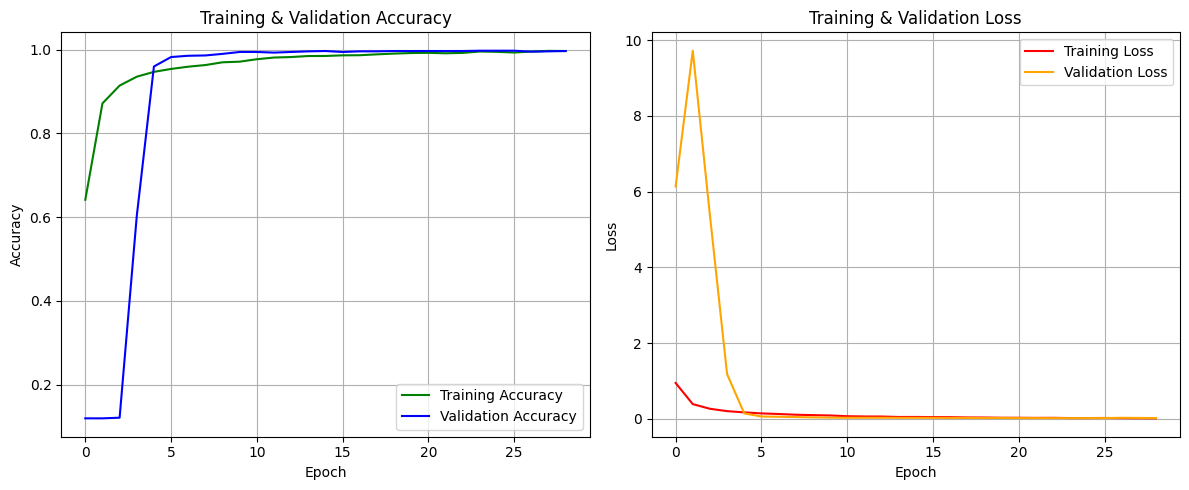

In [15]:
# Visualisasi Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Visualisasi Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1330/1330 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step


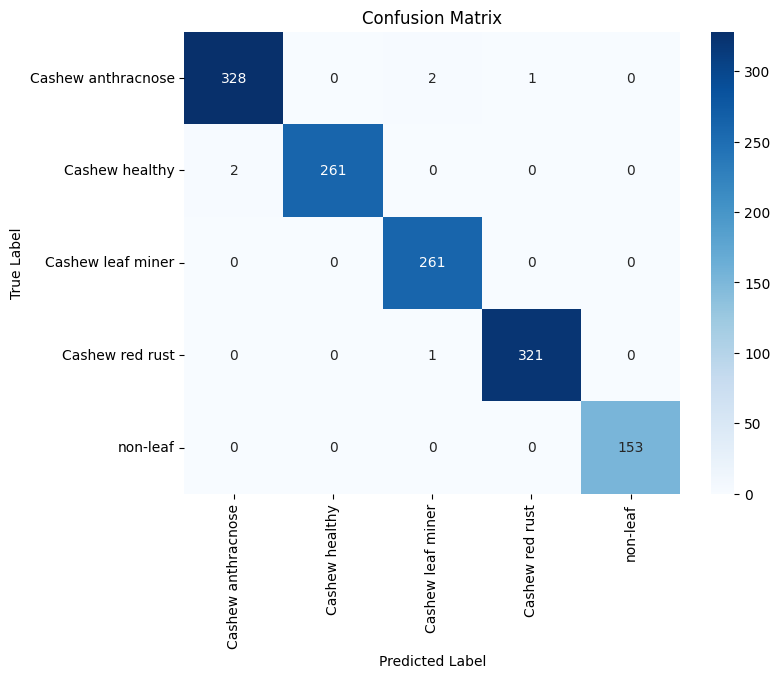

Classification Report:
                    precision    recall  f1-score   support

Cashew anthracnose       0.99      0.99      0.99       331
    Cashew healthy       1.00      0.99      1.00       263
 Cashew leaf miner       0.99      1.00      0.99       261
   Cashew red rust       1.00      1.00      1.00       322
          non-leaf       1.00      1.00      1.00       153

          accuracy                           1.00      1330
         macro avg       1.00      1.00      1.00      1330
      weighted avg       1.00      1.00      1.00      1330



In [16]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Saving healthy1001_.jpg to healthy1001_.jpg


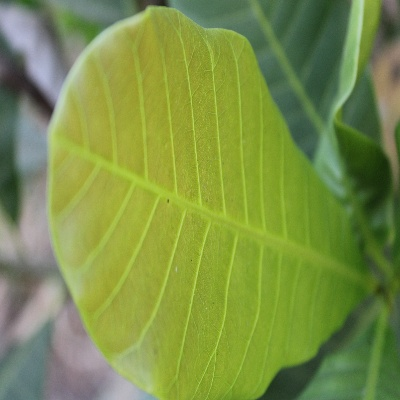

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Prediksi: Cashew healthy (100.00%)


In [24]:
uploaded = files.upload()

for fn in uploaded.keys():
    display(Image(filename=fn))

    img = image.load_img(fn, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    pred = model.predict(img_array)
    confidence = np.max(pred)
    class_idx = np.argmax(pred, axis=1)[0]
    class_labels = list(train_generator.class_indices.keys())

    predicted_class = class_labels[class_idx]

    threshold = 0.6
    if predicted_class == 'non-leaf' or confidence < threshold:
        print(f"\n⚠️ Gambar ini kemungkinan BUKAN daun tanaman jambu mete.")
        print(f"Prediksi: {predicted_class} ({confidence * 100:.2f}%)")
    else:
        print(f"\nPrediksi: {predicted_class} ({confidence * 100:.2f}%)")

In [25]:
model.save('model_cashew_disease.h5')
print("Model berhasil disimpan ke 'model_cashew_disease.h5'")

Model berhasil disimpan ke 'model_cashew_disease.h5'
